In [1]:
#Import the game
import gym_super_mario_bros
# import the joypad wrapper
from nes_py.wrappers import JoypadSpace
# import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [2]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
print(env.action_space, " actions that can be played")
env = JoypadSpace(env, SIMPLE_MOVEMENT) # Simplify the movement set making it easier for the AI to learn
print(env.action_space, " actions that can be played")

Discrete(256)  actions that can be played
Discrete(7)  actions that can be played


In [8]:
env.observation_space.shape # frame shape

(240, 256, 3)

In [39]:
env.action_space.shape # Number of actions
SIMPLE_MOVEMENT[env.action_space.sample()] # random action

['A']

In [ ]:
#Create a flag restart or not
done = True
for frame in range(100000): # looping through every set of frame every frame were doing an action
    # Start the game at first loop
    if done:
        
        env.reset() # restart the game
    state,reward, done,info = env.step(env.action_space.sample()) # step allows us to pass an action to the game
    env.render()
env.close()

In [4]:
env.close()

In [4]:
state = env.reset()

In [5]:
# 4 things returned : frame, survived or not, character attributes
env.step(1)[2]

False

#### 2.Preprocess Environnement

In [ ]:
# we want to grascale the frames make it easier to process stack up consecutive frame to give context to an ai GET AN IDEA OF CHARACTERS VELOCITY? SPEED
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [ ]:
# Install stable baselines for RL stuff
%pip install stable-baselines3[extra] 

In [3]:
# Import Frrame Stacker Wrapper andd Grayscaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv # depends on pytorch
# Import Matplotlib
from matplotlib import pyplot as plt

c:\Users\Ahouz\anaconda3\envs\ytb_proj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# 1. Create the base environnement
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2.Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT) # Simplify the movement set making it easier for the AI to learn
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim = True)
# 4.Wrap it inside the Dummy environnement
env = DummyVecEnv([lambda : env]) # (240,256,1) becomes (1,240,256,1)
# 5.Stack the frames
env = VecFrameStack(env, 4 ,channels_order = 'last')

In [14]:
state = env.reset()

In [15]:
state.shape

(1, 240, 256, 4)

In [21]:
state,reward, done,info = env.step([5])

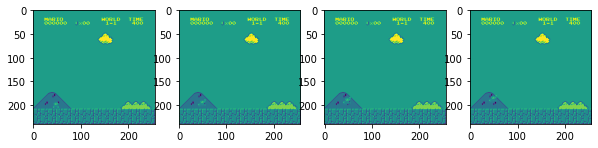

In [22]:
# matplotlib to show the game frame
plt.figure(figsize= (10,8))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx + 1)
    plt.imshow(state[0][:,:,idx])
plt.show()

#### Train the RL Model

In [4]:
# import os fopr file management
import os
# import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback


In [5]:
# little bit of code to save the model every 10 000 steps or so we dont lose progress
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [6]:
CHECKPOINT_DIR = "./Models"
LOG_DIR = './logs'


In [7]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq = 10000, save_path= CHECKPOINT_DIR)


In [12]:
model = PPO('CnnPolicy' , env, verbose = 1,tensorboard_log = LOG_DIR, learning_rate=0.000001,n_steps = 512)


Using cuda device
Wrapping the env in a VecTransposeImage.


In [26]:
# train the AI model, this is where the AI model start to learn
model.learn(total_timesteps = 1000000, callback = callback)

Logging to ./logs\PPO_1
----------------------------
| time/              |     |
|    fps             | 143 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 89           |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 8.546666e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | 0.0284       |
|    learning_rate        | 1e-06        |
|    loss                 | 135          |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.000227    |
|    value_loss           | 394          |
------------------------------------------

#### 4.TEST IT OUT

In [12]:
# Load model
model = PPO.load(CHECKPOINT_DIR + "/best_model_1010000.zip")

In [13]:
state = env.reset()

In [14]:
SIMPLE_MOVEMENT[model.predict(state)[0][0]]

['right', 'A', 'B']

In [ ]:
# Start the game
state = env.reset()
# Loop through the game
while True :
    
    action,state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()
